<a href="https://colab.research.google.com/github/Nongbon/208499/blob/main/draft_lable_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!wget https://raw.githubusercontent.com/Nongbon/208499/main/ETH-USD.csv

--2021-09-13 11:28:37--  https://raw.githubusercontent.com/Nongbon/208499/main/ETH-USD.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166232 (162K) [text/plain]
Saving to: ‘ETH-USD.csv.1’

ETH-USD.csv.1       100%[===================>] 162.34K  --.-KB/s    in 0.02s   

2021-09-13 11:28:37 (7.09 MB/s) - ‘ETH-USD.csv.1’ saved [166232/166232]



In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
data = pd.read_csv("ETH-USD.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-07,2.831620,3.536610,2.521120,2.772120,2.772120,1.643290e+05
1,2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,6.741880e+05
2,2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,5.321700e+05
3,2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,4.052830e+05
4,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1.463100e+06
...,...,...,...,...,...,...,...
2217,2021-09-01,3430.762451,3836.867432,3387.408447,3834.828125,3834.828125,3.007089e+10
2218,2021-09-02,3825.027832,3830.711426,3726.750488,3790.989990,3790.989990,2.438740e+10
2219,2021-09-03,3787.486572,4022.469238,3712.678223,3940.614746,3940.614746,2.620777e+10
2220,2021-09-04,3937.910156,3969.448730,3837.931152,3887.828369,3887.828369,2.080696e+10


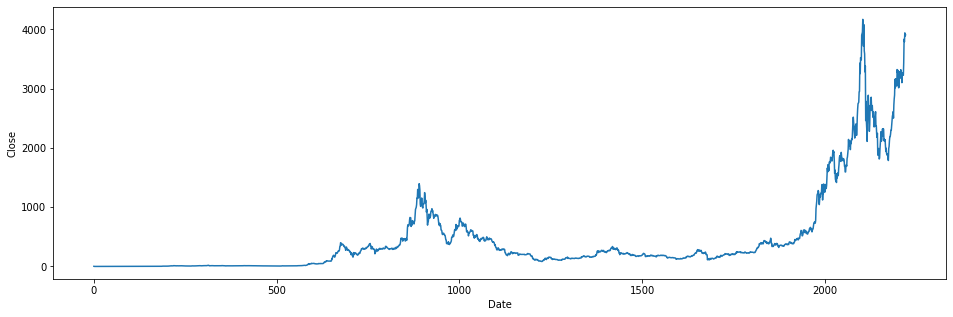

In [22]:
plt.figure(figsize=(16,5))
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

In [54]:
n = len(data)

In [65]:
for i in range(len(data)):
  if i+1 < n :
    data['label'][i+1] = data['Close'][i+1] / data['Close'][i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
for i in range(len(data)) :
  if data['label'][i] > 1 :
    data['Y'][i] = 1
  else : 
    data['Y'][i] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [68]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,label,Y
0,2015-08-07,2.831620,3.536610,2.521120,2.772120,2.772120,1.643290e+05,0.271751,0
1,2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,6.741880e+05,0.271751,0
2,2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,5.321700e+05,0.931732,0
3,2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,4.052830e+05,1.009333,1
4,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1.463100e+06,1.507323,1
...,...,...,...,...,...,...,...,...,...
2217,2021-09-01,3430.762451,3836.867432,3387.408447,3834.828125,3834.828125,3.007089e+10,1.116810,1
2218,2021-09-02,3825.027832,3830.711426,3726.750488,3790.989990,3790.989990,2.438740e+10,0.988568,0
2219,2021-09-03,3787.486572,4022.469238,3712.678223,3940.614746,3940.614746,2.620777e+10,1.039469,1
2220,2021-09-04,3937.910156,3969.448730,3837.931152,3887.828369,3887.828369,2.080696e+10,0.986605,0


In [44]:
data.to_csv("label.csv")